In [25]:
from collections import defaultdict
import os

def get_imagefiles(root):
    images = []
    for root, _, files in os.walk(root):
        for file in files:
            if file.endswith(("jpg", "jpeg", "png")):
                images.append(os.path.join(root, file))
    return images

def validate(images, labels):
    if len(images) != len(labels):
        print(f"Number of images and labels do not match: {len(images)} images, {len(labels)} labels")
        return
    
    images = sorted(images)
    labels = sorted(labels)

    correct, incorrect = [], []
    for img, lbl in zip(images, labels):
        img_name = ".".join(os.path.basename(img).split(".")[:-1])
        lbl_name = ".".join(os.path.basename(lbl).split(".")[:-1])
        if img_name != lbl_name:
            incorrect.append((img, lbl))
        else:
            correct.append((img, lbl))

    if len(incorrect) > 0:
        print(f"Correct: {len(correct)}")
        print(f"Incorrect: {len(incorrect)}")
        return False
    
    return True


def visualize(images, labels, id2label_dict):
    from PIL import Image, ImageDraw, ImageFont
    import matplotlib.pyplot as plt
    import numpy as np
    font = ImageFont.truetype(r"D:\workspace\doc-understanding\assets\MontserratMedium.ttf", size=60)
    
    for img, lbl in zip(images, labels):
        plt.figure(figsize=(10, 10))
        img = Image.open(img)
        lbl = open(lbl, "r", encoding="utf-8").readlines()
        bboxes = [list(map(float, line.split()[1:])) for line in lbl]
        cls = [line.split()[0] for line in lbl]
        draw = ImageDraw.Draw(img)
        for c, bbox in zip(cls, bboxes):
            xc, yc, w, h = bbox
            x1, y1 = int((xc - w/2) * img.width), int((yc - h/2) * img.height)
            x2, y2 = int((xc + w/2) * img.width), int((yc + h/2) * img.height)
            try:
                draw.rectangle([x1, y1, x2, y2], outline="red")
                draw.text((int((x1 + x2)/
                2), int((y1 + y2)/2)),
                        id2label_dict[int(c)], fill="red", font=font)
            except:
                pass
        plt.imshow(np.array(img))
        plt.show()


def get_class_distribution(labels):
    class_dist = defaultdict(int)
    for lbl in labels:
        with open(lbl, "r", encoding="utf-8") as f:
            for line in f.readlines():
                class_dist[line.split()[0]] += 1
    return class_dist

def move_files(src_dir, dst_dir):
    os.makedirs(dst_dir, exist_ok=True)
    for file in os.listdir(src_dir):
        os.rename(os.path.join(src_dir, file), os.path.join(dst_dir, file))

def merge_train_val_test(root):
    train_dir = os.path.join(root, "train")
    val_dir = os.path.join(root, "val")
    test_dir = os.path.join(root, "test")

    dst_img_dir = os.path.join(root, "images")
    dst_lbl_dir = os.path.join(root, "labels")
    os.makedirs(dst_img_dir, exist_ok=True)
    os.makedirs(dst_lbl_dir, exist_ok=True)

    move_files(os.path.join(train_dir, "images"), dst_img_dir)
    move_files(os.path.join(val_dir, "images"), dst_img_dir)
    move_files(os.path.join(test_dir, "images"), dst_img_dir)

    move_files(os.path.join(train_dir, "labels"), dst_lbl_dir)
    move_files(os.path.join(val_dir, "labels"), dst_lbl_dir)
    move_files(os.path.join(test_dir, "labels"), dst_lbl_dir)


def create_all_images_list(baseroot, save=False):
    images = []
    for root, _, files in os.walk(baseroot):
        for file in files:
            if file.endswith(("jpg", "jpeg", "png")):
                images.append(os.path.join(root, file))
    if save:
        savepath = os.path.join(baseroot, "images.txt")
        with open(savepath, "w+") as f:
            for img in images:
                f.write(os.path.relpath(img, baseroot) + "\n")
        return savepath
    return images

def train_val_split(imagelist, dst_dir, val_split=0.1, save=False):
    os.makedirs(dst_dir, exist_ok=True)
    
    import random
    random.seed(111)
    random.shuffle(imagelist)
    
    val_size = int(len(imagelist) * val_split)
    if save:
        trainpath = os.path.join(dst_dir, "train.txt")
        valpath = os.path.join(dst_dir, "val.txt")
        with open(trainpath, "w+") as f:
            for img in imagelist[val_size:]:
                f.write(img if img.endswith("\n") else img + "\n")
        with open(valpath, "w+") as f:
            for img in imagelist[:val_size]:
                f.write(img if img.endswith("\n") else img + "\n")
        return trainpath, valpath
    return imagelist[:val_size], imagelist[val_size:]


def change_cid(labels_dir, cid_mapping):
    for lbl in os.listdir(labels_dir):
        with open(os.path.join(labels_dir, lbl), "r", encoding="utf-8") as f:
            lines = f.readlines()
        with open(os.path.join(labels_dir, lbl), "w", encoding="utf-8") as f:
            for line in lines:
                cid, *bbox = line.split()
                if cid in cid_mapping.keys():
                    if cid_mapping[cid] == "-1":
                        continue
                    cid = cid_mapping[cid]
                f.write(f"{cid} {' '.join(bbox)}\n")


def x1y1x4y4_to_xcycwh(labels_dir):
    for lbl in os.listdir(labels_dir):
        with open(os.path.join(labels_dir, lbl), "r", encoding="utf-8") as f:
            lines = f.readlines()
        with open(os.path.join(labels_dir, lbl), "w", encoding="utf-8") as f:
            for line in lines:
                
                cid, *bbox = line.split()
                if len(bbox) == 4:
                    return
                bbox = list(map(float, bbox))
                x_vals = bbox[::2]
                y_vals = bbox[1::2]

                xmin, xmax = min(x_vals), max(x_vals)
                ymin, ymax = min(y_vals), max(y_vals)

                xc = (xmin + xmax) / 2
                yc = (ymin + ymax) / 2
                w = xmax - xmin
                h = ymax - ymin

                f.write(f"{cid} {xc} {yc} {w} {h}\n")

## D4LA

In [26]:
# D4LA
id2label = {
    0: "doc_title",
    1: "para_title",
    2: "para_text",
    3: "list_text",
    4: "region_title",
    5: "date",
    6: "letter_head",
    7: "letter_dear",
    8: "letter_sign",
    9: "question",
    10: "other_text",
    11: "region_kv",
    12: "region_list",
    13: "abstract",
    14: "author",
    15: "table_name",
    16: "table",
    17: "figure",
    18: "figure_name",
    19: "equation",
    20: "reference",
    21: "footnote",
    22: "page_header",
    23: "page_footer",
    24: "number",
    25: "catalog",
    26: "page_number"
}


base_root = r"X:\doc_layout_analysis\D4LA"
root = os.path.join(base_root)

11092 11092
doc_title : 9284
para_text : 40728
other_text: 18932
date      : 3934
number    : 9122
region_title: 6821
list_text : 5718
region_list: 4632
page_header: 4874
table     : 3389
region_kv : 15269
para_title: 6295
page_footer: 3961
letter_sign: 913
page_number: 2613
question  : 169
figure    : 2793
table_name: 818
figure_name: 380
letter_head: 697
letter_dear: 1099
footnote  : 812
abstract  : 1007
equation  : 74
author    : 1755
reference : 722
catalog   : 35


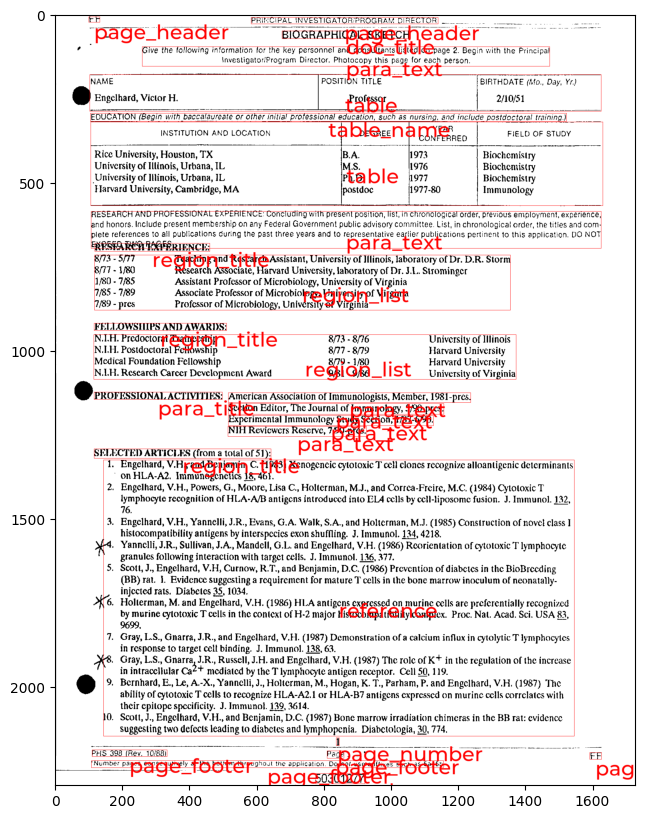

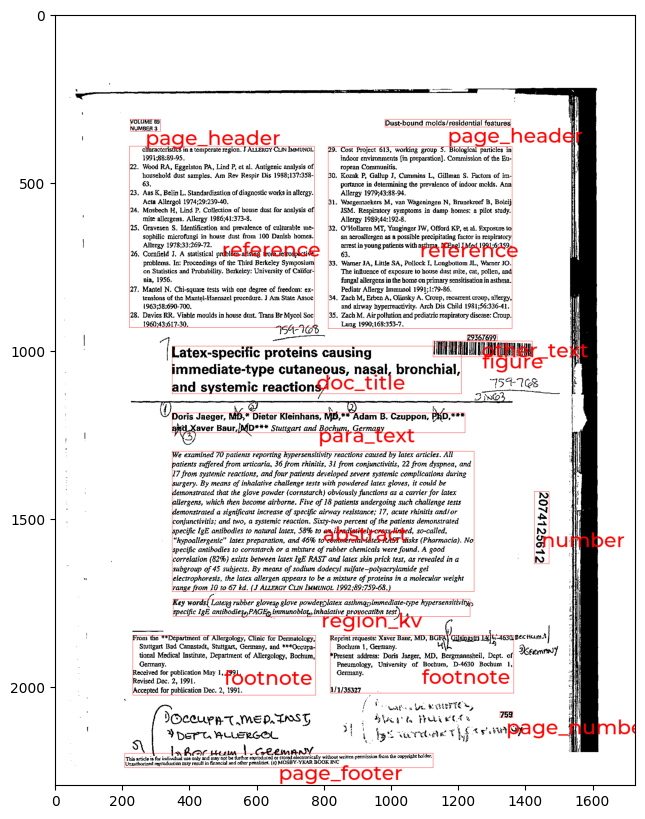

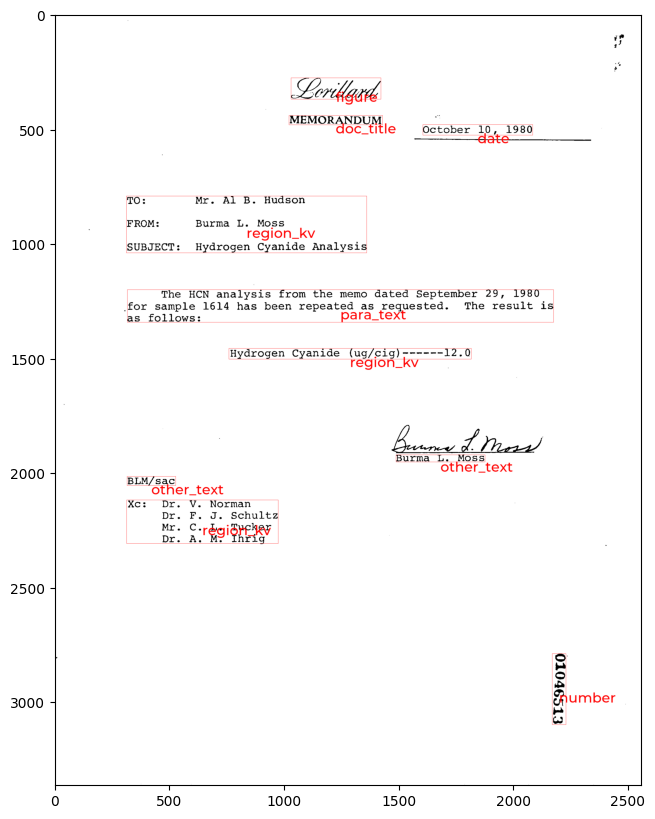

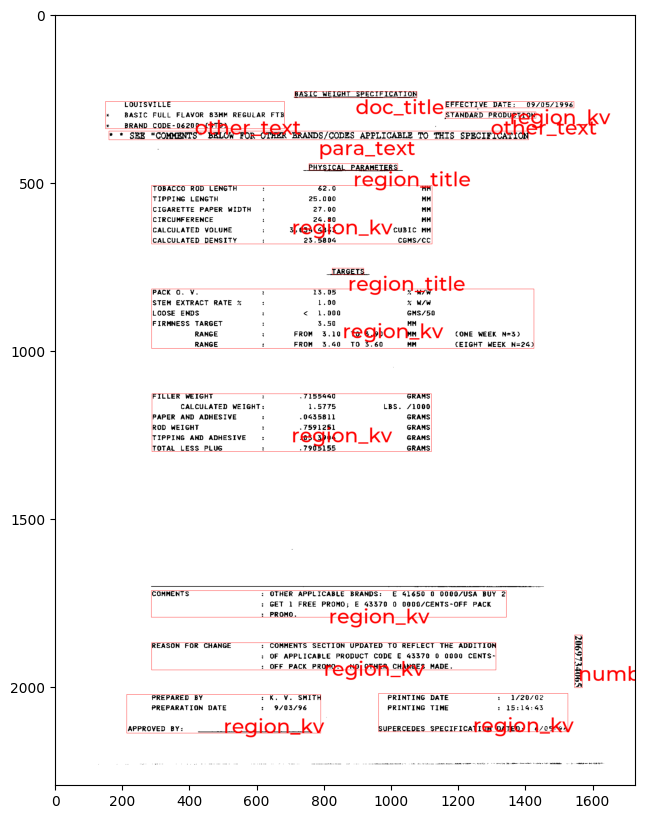

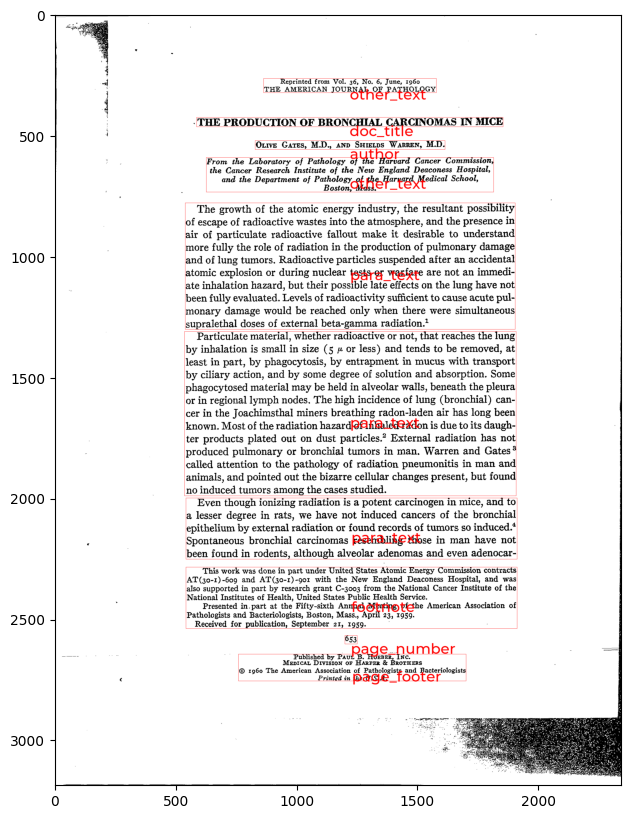

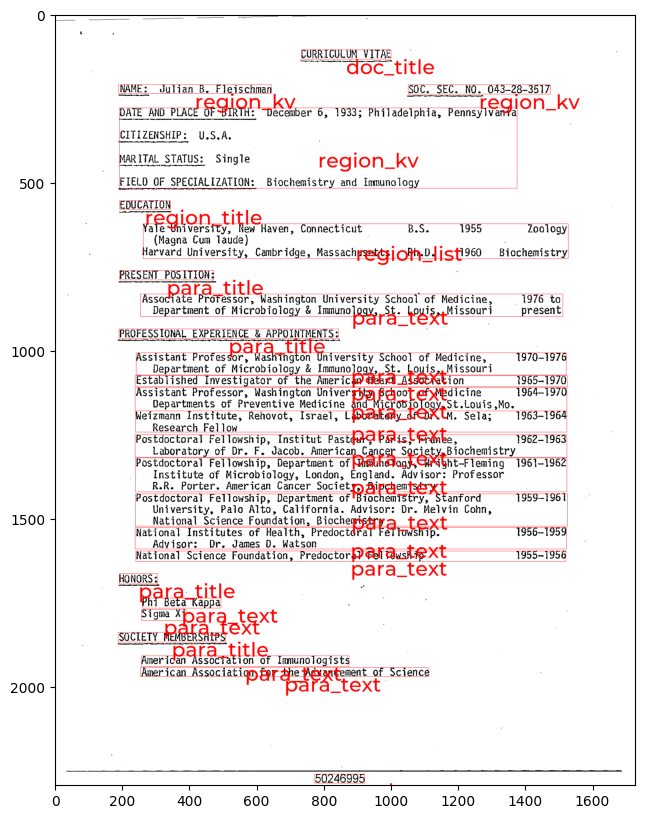

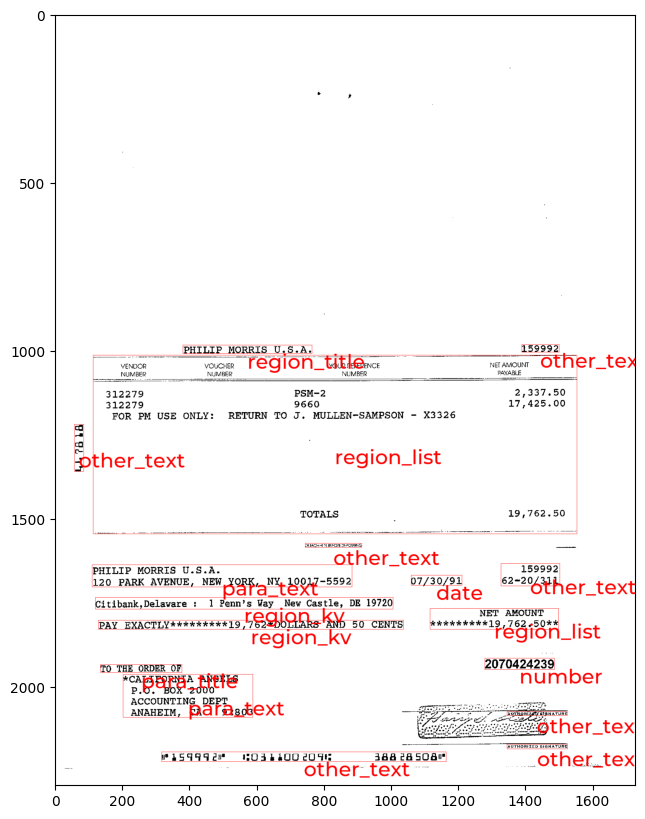

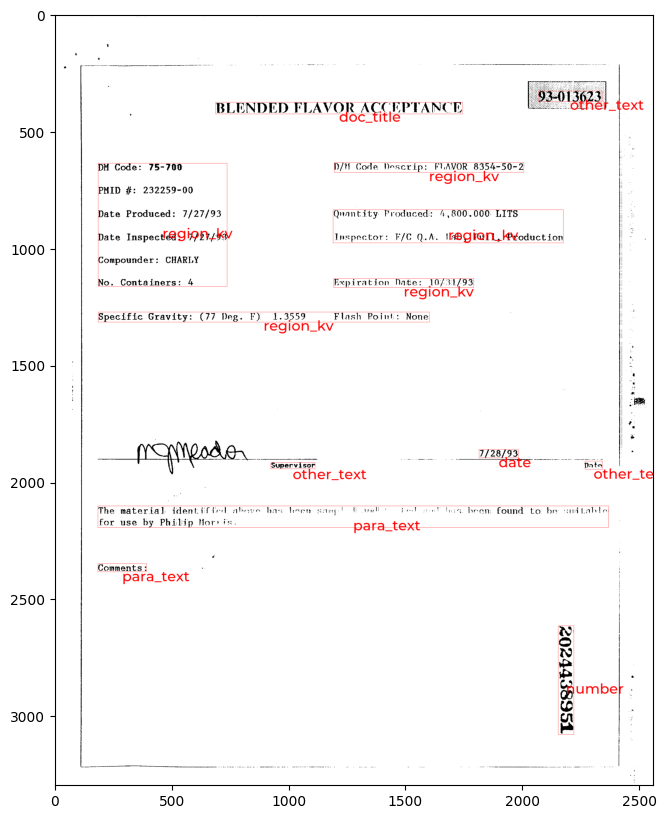

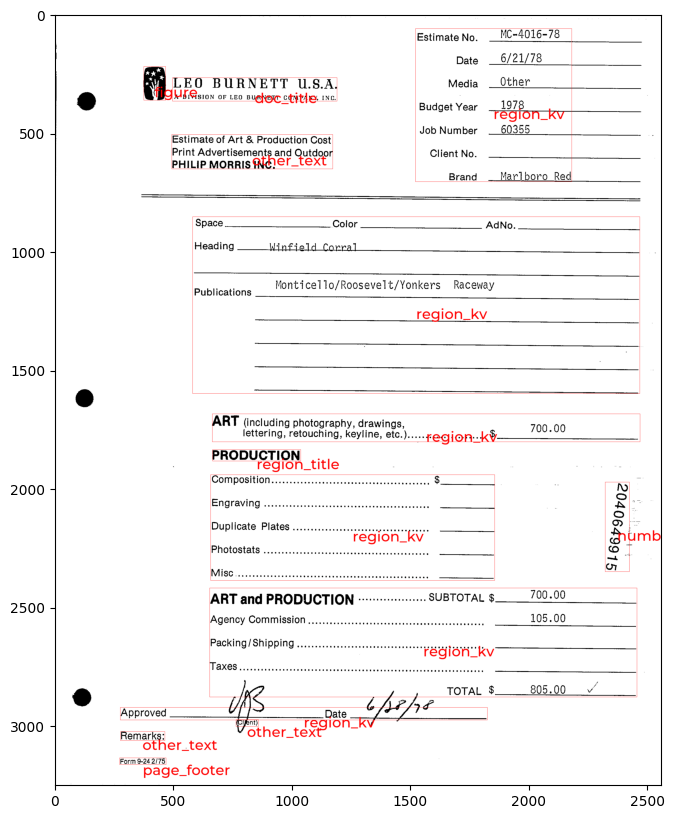

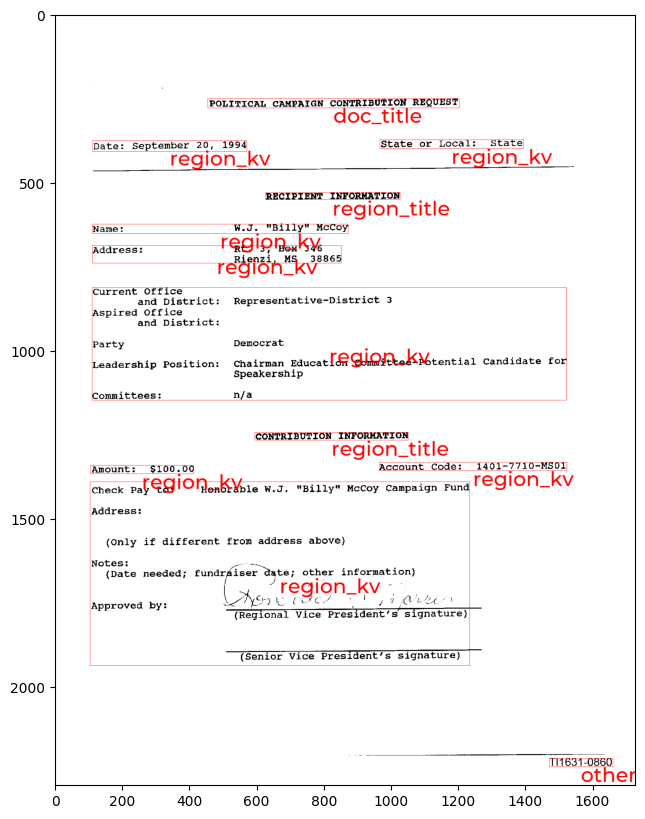

In [27]:
import random

image_dir = os.path.join(root, "images")
label_dir = os.path.join(root, "labels")

images = [os.path.join(image_dir, img) for img in os.listdir(image_dir) if img.endswith((".jpg", ".png", ".jpeg"))]
labels = [os.path.join(label_dir, lbl) for lbl in os.listdir(label_dir) if lbl.endswith(".txt")]

validate(images, labels)
print(len(images), len(labels))
class_dist = get_class_distribution(labels)

# Convert label format
x1y1x4y4_to_xcycwh(label_dir)	

for k, v in class_dist.items():
    print(f"{id2label[int(k)]:<10}: {v}")
random_indices = random.sample(range(len(images)), 10)
random_images = [images[i] for i in random_indices]
random_labels = [labels[i] for i in random_indices]
visualize(random_images, random_labels, id2label)

In [28]:
new_id2label = {
    0: "text",
    1: "table",
    2: "equation",
    3: "key_value",
    4: "signature"
}

cid_mapping = {
    "0": "0",
    "1": "0",
    "2": "0",
    "3": "0",
    "4": "0",
    "5": "0",
    "6": "0",
    "7": "0",
    "8": "4",
    "9": "0",
    "10": "0",
    "11": "3",
    "12": "3",
    "13": "0",
    "14": "0",
    "15": "0",
    "16": "1",
    "17": "-1",
    "18": "0",
    "19": "2",
    "20": "0",
    "21": "0",
    "22": "0",
    "23": "0",
    "24": "0",
    "25": "0",
    "26": "0"
}

change_cid(label_dir, cid_mapping)


text      : 119776
key_value : 19901
table     : 3389
signature : 913
equation  : 74


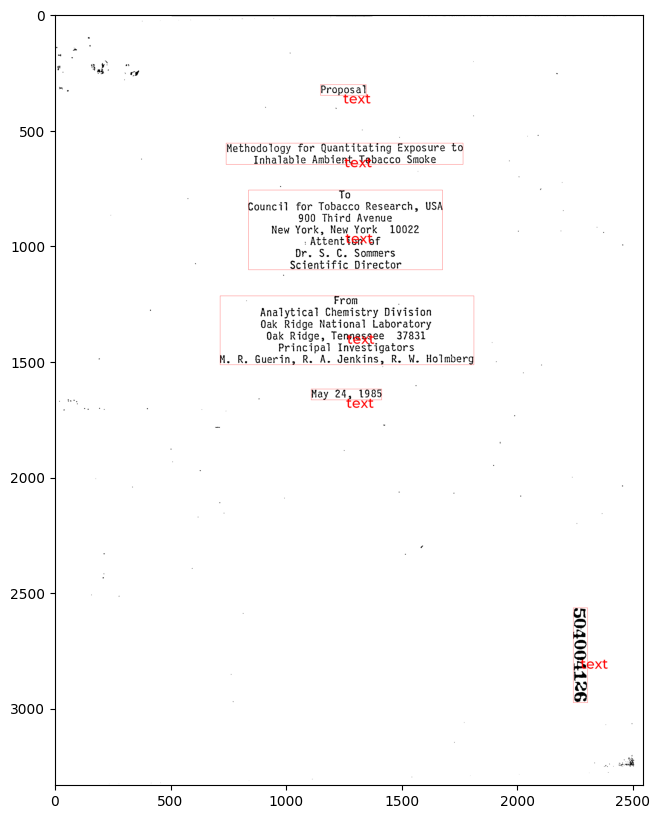

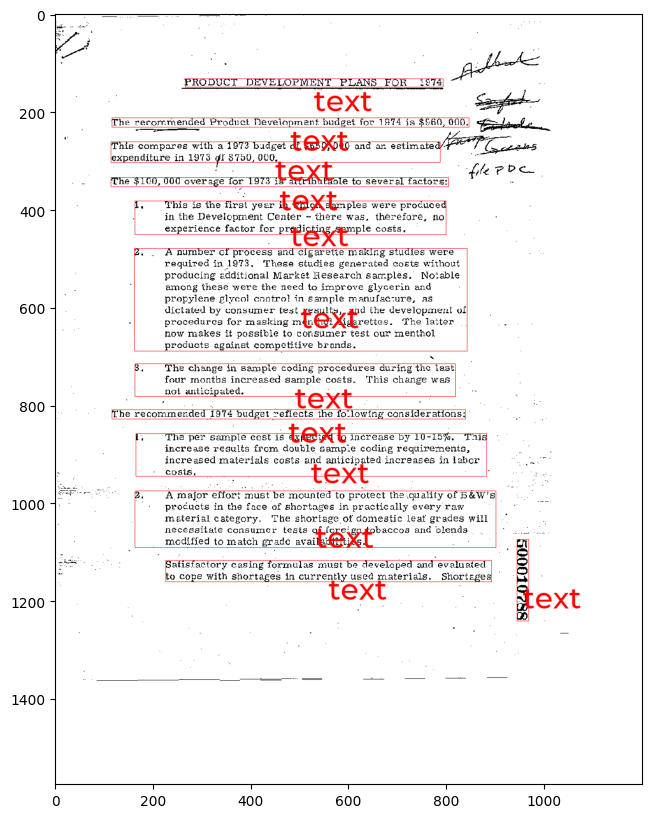

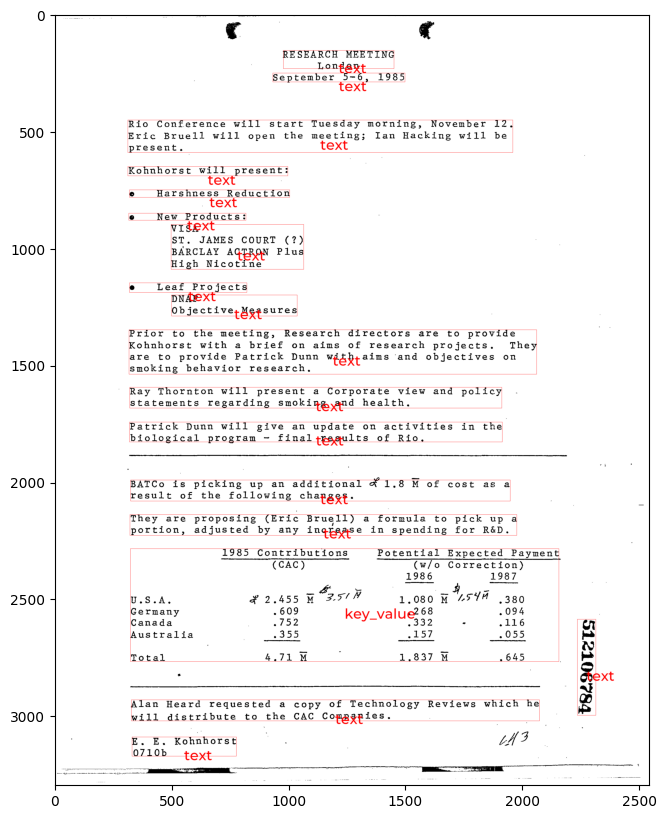

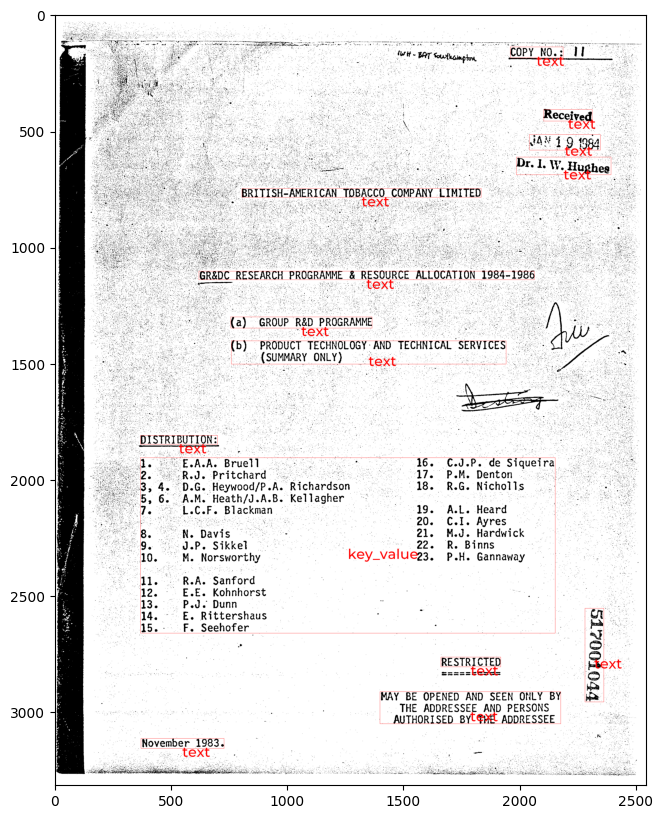

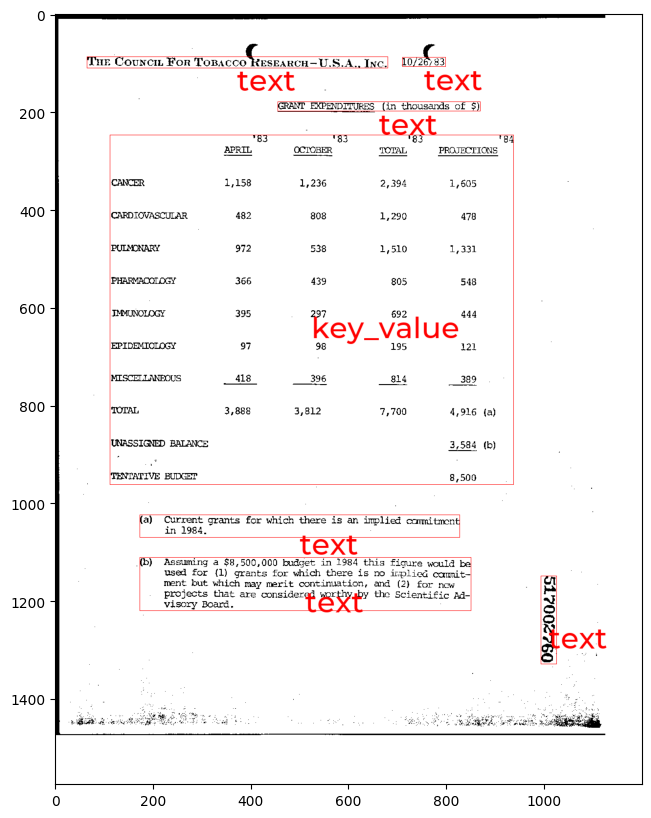

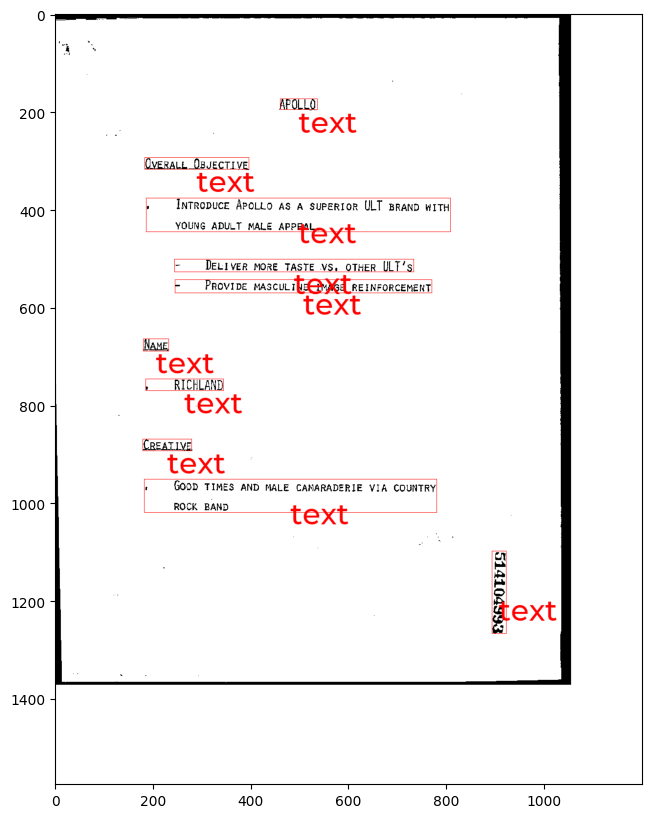

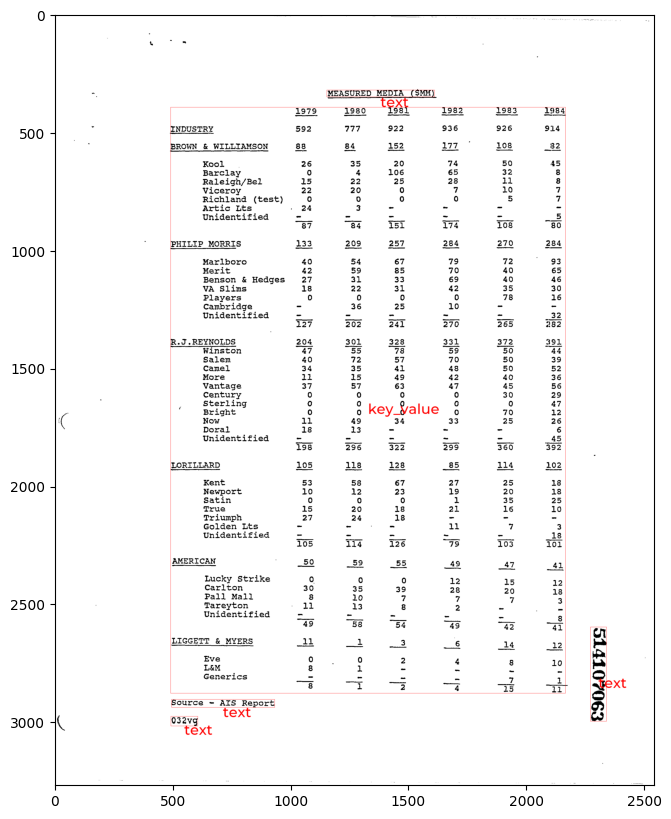

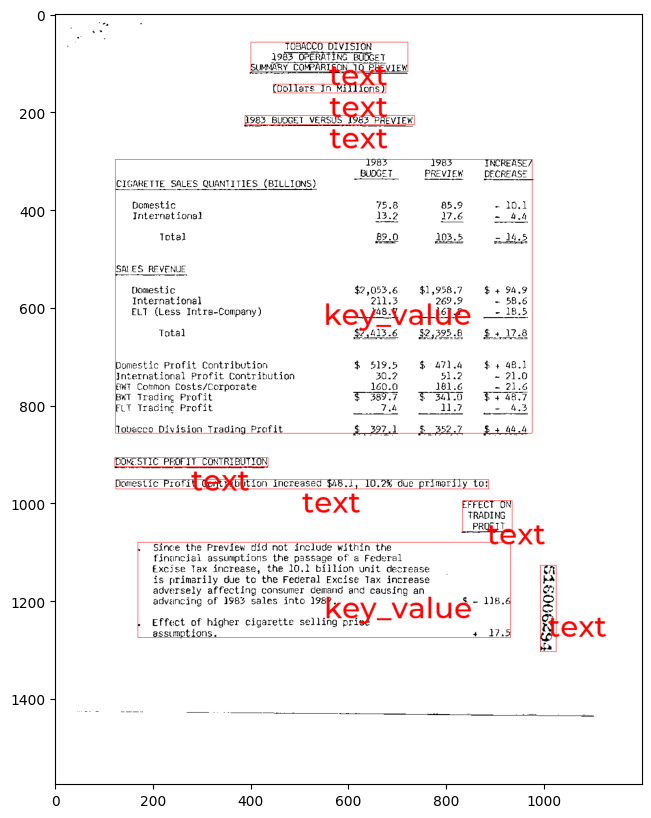

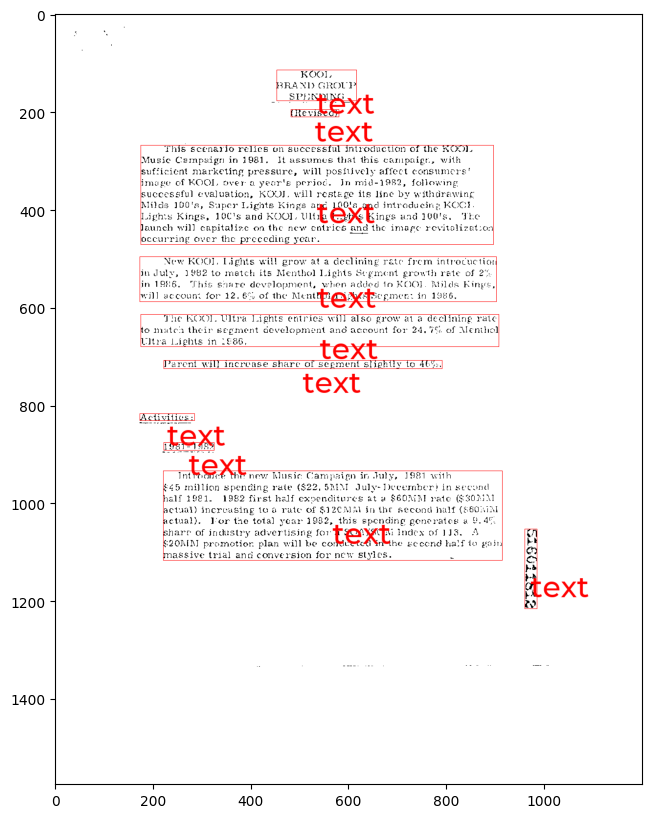

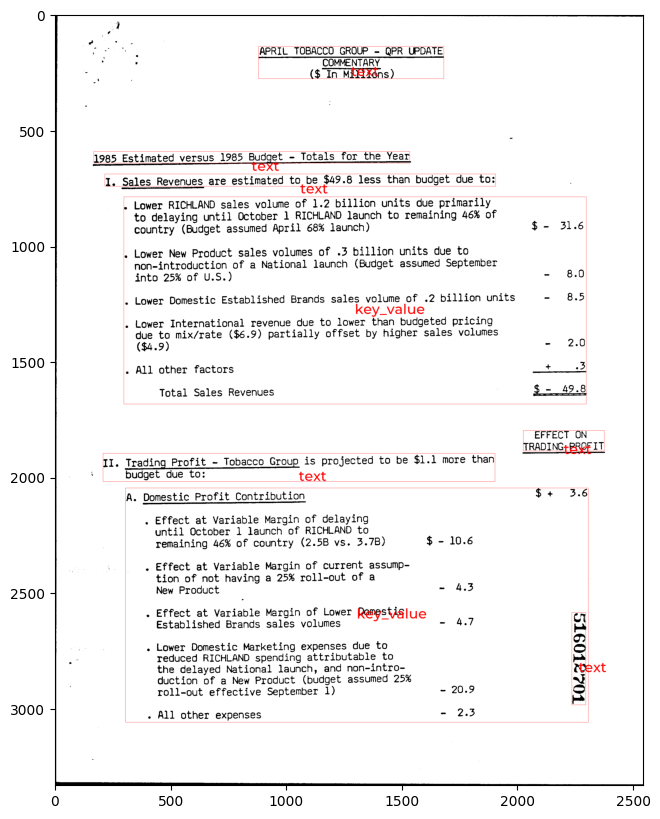

In [29]:
images = [os.path.join(image_dir, img) for img in os.listdir(image_dir) if img.endswith(("jpg", "png", "jpeg"))]
labels = [os.path.join(label_dir, lbl) for lbl in os.listdir(label_dir) if lbl.endswith(".txt")]
validate(images, labels)
class_dist = get_class_distribution(labels)

for k, v in class_dist.items():
    print(f"{new_id2label[int(k)]:<10}: {v}")

random_images = images[:10]
random_labels = labels[:10]
visualize(random_images, random_labels, new_id2label)

In [30]:
imagelist_path = create_all_images_list(base_root, save=True)
dst_dir = os.path.join(base_root)
imagelist = open(imagelist_path, "r").readlines()
trainlist_path, vallist_path = train_val_split(imagelist, dst_dir, val_split=0.1, save=True)
